# Dopamine modulation on BG

**Observation**: increase in beta-range spectral power is observed without dopamine modulation of CTX input to MSN-D1 and MSN-D2.

**Method**: I used the network model from Ortone and the model of dopamine modulation from Lindahl(2016). In particular, if an attribute $x$ of the network is subject to dopaminergic modulation, the effect of dopamine levels are modeled by

$$ x(\alpha) = x_0(1+\chi_x (\alpha -\alpha_0))$$
where $\alpha$ represents the dopamine level and $x_0$ is the value of the parameter at standard dopamine ($\alpha_0 = 0.8$, Lindahl). In the following, $\chi_x$ will be called generalized susceptibility.

In [1]:
import yaml
from rich import print

NEURONS_FILE = "ortone_neurons.yaml"
NETWORK_FILE = "ortone_network.yaml"
DOPAMINE_FILE = "lindahl_dopamine_susceptibility.yaml"

with open(DOPAMINE_FILE, "r") as dopfile:
    susceptiblities = yaml.safe_load(dopfile)['parametric']['dopamine']

for item in susceptiblities:
    if 'population' in item.keys():
        print(f"Attribute {item['attribute']:10} of population {item['population']:15}: chi = {item['susceptibility']}")
    elif 'projection' in item.keys():
        print(f"Attribute {item['attribute']:10} of projection {item['projection']:15}: chi = {item['susceptibility']}")

Attribute E_l        of population FSN            : chi = -0.078

Attribute E_l        of population GPeTA, GPeTI   : chi = -0.181

Attribute V_peak     of population D1             : chi = 0.0296

Attribute ada_b      of population D1             : chi = -0.45

Attribute E_l        of population SNR            : chi = -0.0896

Attribute weight     of projection FSN->FSN       : chi = -1.27

Attribute weight     of projection GPeTA->FSN     : chi = -0.53

Attribute weight     of projection GPeTI->FSN     : chi = -0.53

Attribute weight     of projection GPeTA->GPeTA, GPeTA->GPeTI, GPeTI->GPeTI,  GPeTI->GPeTA: chi = -0.83

Attribute weight     of projection D2->GPeTI      : chi = -0.83

Attribute weight     of projection STN->GPeTA     : chi = -0.45

Attribute weight     of projection STN->GPeTI     : chi = -0.45

Attribute connectivity of projection FSN->D2        : chi = -0.9

Attribute connectivity of projection D1->D1, D1->D2, D2->D1, D2->D2: chi = 0.88

Attribute weight     of projection D1->D1, D1->D2, D2->D1, D2->D2: chi = 0.88

Attribute weight     of projection GPeTA->D1      : chi = -1.15

Attribute weight     of projection D1->SNR        : chi = 0.56

Attribute weight     of projection GPeTI->STN     : chi = -0.24

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# %load_ext autoreload
# %autoreload 2
%matplotlib inline
# %matplotlib ipympl

# FSN [10-20] Hz 
# D1, D2 [0.5–2.5] Hz
# GPe-TI [40–60] Hz
# GPe-TA [5–15] Hz 
# and STN [12–20] Hz

## Parameters of the simulation

In [3]:
Tlong = 8000  # ms
dt = 0.1      # ms

points_per_bin = 1/dt     # bins 1 ms wide
sampling_frequency = 1e3  # 1 kHz sampling frequency
burn_in_millis = 600      # the first part of the record to discard (ms)

# Params for trials
n_trials = 10
Tshort = 1500 # ms

## Utils & plots

In [4]:
from scipy.signal import butter, sosfiltfilt, freqz, welch
from scipy.integrate import simpson
from scipy.stats import entropy

def bin_spikes(spikes, points_per_bin = 10):
    binned_signal = np.sum( spikes[:(len(spikes)//points_per_bin)*points_per_bin].reshape(-1, points_per_bin),
                        axis=1).squeeze()
    return binned_signal

def beta_power(sn, population):    
    spikes = sn.populations[population].get_data('spikes')
    binned_spikes = bin_spikes(spikes)[burn_in_millis:]
    T = len(binned_spikes)
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg = T/2, # Takes at least 3 windows
                   noverlap= T/4,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')
    print(f"f peak {f[np.argmax(PSD)]}")
    beta_mask = (f>12)&(f<30)
    return np.trapz(PSD[beta_mask], x=f[beta_mask])

def bandpass(data, edges, sample_rate, poles = 5):
    sos = butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

In [5]:
def plot_spectrum(sn, scale="log"):
    fig, axes = plt.subplots(len(sn.populations), 1, sharex=True)
    for ax, pop in zip(axes, sn.populations):
        spikes = sn.populations[pop].get_data('spikes')
        binned_spikes = bin_spikes(spikes)
        binned_spikes = binned_spikes[burn_in_millis:]
        T = len(binned_spikes)
        print(f"Mean firing rate {pop} is {np.sum(spikes)/sn.populations[pop].n_neurons/(Tlong/1000) :.1f} Hz")
        f, PSD = welch(binned_spikes, 
                       sampling_frequency, 
                       nperseg=T/2, 
                       noverlap=T/4,
                       nfft=None, 
                       scaling='density', 
                       window='hamming')
    
        norm = simpson(PSD, x=f)
        ax.plot(f, PSD/norm, label=pop)
        
        ax.set_ylabel(pop)
        ax.set_yscale(scale)
    print(f"F resolution { f[1] - f[0] :.2f} Hz")
    # plt.yscale('log')
    # plt.legend()
    # plt.ylabel("normalized PSD")
    plt.xlabel("Frequency [Hz]")
    plt.xlim(0,150)
    fig.set_figheight(8.5)
    
def plot_signals(sn):
    fig, axes = plt.subplots(len(sn.populations), 1, sharex=True)
    for ax, pop in zip(axes, sn.populations):
        binned_spikes = bin_spikes(sn.populations[pop].get_data('spikes'))
        instantaneous_fr = binned_spikes/sn.populations[pop].n_neurons*1000
        
        tt = np.linspace(0, len(instantaneous_fr)/1000, len(instantaneous_fr))
        ax.plot(tt, instantaneous_fr)
        ax.plot(tt, bandpass(instantaneous_fr, [12, 24], sampling_frequency), label="beta")
        ax.plot(tt, bandpass(instantaneous_fr, [30, 140], sampling_frequency), label="gamma")
        ax.set_ylabel(pop)
    # ax.set_xlim(1.5, 2)
    fig.suptitle("Instantaneous firing rate [Hz]")
    ax.set_xlabel("time [s]")
    fig.set_figheight(8.5)

## Building the network

In [6]:
from quilt.interface.spiking import set_verbosity
set_verbosity(1)

In [7]:
from quilt.builder import NeuronCatalogue, ParametricSpikingNetwork

neuron_catalogue = NeuronCatalogue.from_yaml(NEURONS_FILE)
sn = ParametricSpikingNetwork.from_yaml(NETWORK_FILE, 
                                        DOPAMINE_FILE, 
                                        neuron_catalogue)
sn.monitorize_spikes()

In [8]:
# from quilt.view import plot_graph
# fig, ax = plt.subplots()
# plot_graph(sn)
# plt.show()

## Control case (healthy subject)

In [9]:
sn.set_parameters(dopamine=1.0)
sn.run(dt=dt, time=Tlong)

Output()

Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 138 s	(1.72683 ms/step)
	Gathering time avg: 0.0533375 us/step
	Inject time avg: 190.401 us/step
Population evolution stats:
	0:
		evolution:	470.918 us/step	---	78 ns/step/neuron
		spike emission:	41.733 us/step	---	6 ns/step/neuron
	1:
		evolution:	455.33 us/step	---	75 ns/step/neuron
		spike emission:	69.5225 us/step	---	11 ns/step/neuron
	2:
		evolution:	85.4546 us/step	---	203 ns/step/neuron
		spike emission:	11.477 us/step	---	27 ns/step/neuron
	3:
		evolution:	113.002 us/step	---	144 ns/step/neuron
		spike emission:	21.5813 us/step	---	27 ns/step/neuron
	4:
		evolution:	60.8388 us/step	---	233 ns/step/neuron
		spike emission:	5.41953 us/step	---	20 ns/step/neuron
	5:
		evolution:	71.4338 us/step	---	175 ns/step/neuron
		spike emission:	4.9711 us/step	---	12 ns/step/neuron
	6:
		evolution:	111.834 us/

Mean firing rate D1 is 0.7 Hz

Mean firing rate D2 is 1.5 Hz

Mean firing rate FSN is 16.2 Hz

Mean firing rate GPeTI is 66.3 Hz

Mean firing rate GPeTA is 9.5 Hz

Mean firing rate STN is 13.2 Hz

Mean firing rate SNR is 11.5 Hz

F resolution 0.27 Hz

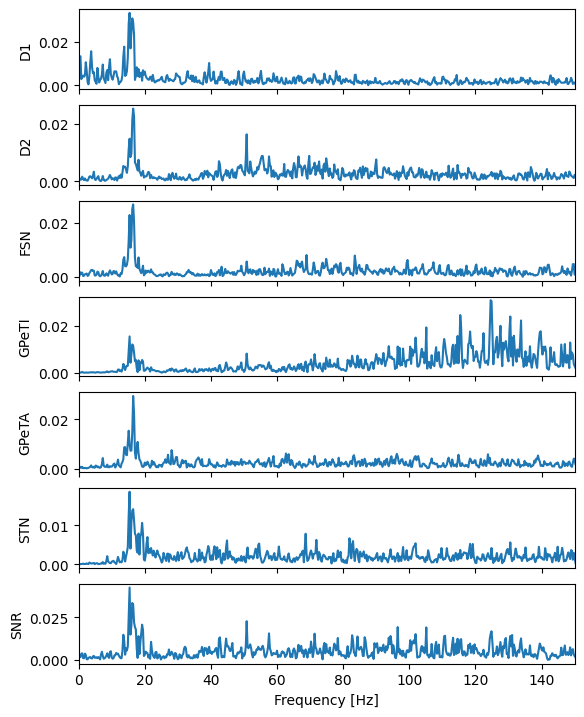

In [10]:
plot_spectrum(sn, scale="linear")

(3.5, 4.0)

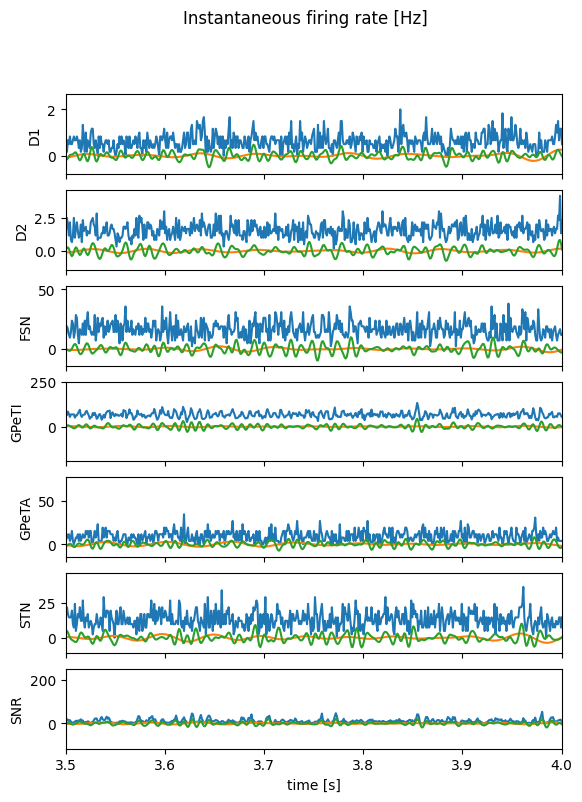

In [11]:
plot_signals(sn)
plt.gca().set_xlim(3.5, 4)

## Lesioned case (PD)

In [12]:
sn.set_parameters(dopamine=0.65)
sn.run(dt=dt, time=Tlong)

Output()

Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 147 s	(1.84452 ms/step)
	Gathering time avg: 0.067975 us/step
	Inject time avg: 207.013 us/step
Population evolution stats:
	0:
		evolution:	513.998 us/step	---	85 ns/step/neuron
		spike emission:	58.6866 us/step	---	9 ns/step/neuron
	1:
		evolution:	476.11 us/step	---	79 ns/step/neuron
		spike emission:	62.6277 us/step	---	10 ns/step/neuron
	2:
		evolution:	91.205 us/step	---	217 ns/step/neuron
		spike emission:	13.124 us/step	---	31 ns/step/neuron
	3:
		evolution:	119.076 us/step	---	152 ns/step/neuron
		spike emission:	20.634 us/step	---	26 ns/step/neuron
	4:
		evolution:	65.0967 us/step	---	250 ns/step/neuron
		spike emission:	5.15356 us/step	---	19 ns/step/neuron
	5:
		evolution:	75.8114 us/step	---	185 ns/step/neuron
		spike emission:	5.4717 us/step	---	13 ns/step/neuron
	6:
		evolution:	116.625 us/st

Mean firing rate D1 is 1.8 Hz

Mean firing rate D2 is 1.4 Hz

Mean firing rate FSN is 14.9 Hz

Mean firing rate GPeTI is 57.7 Hz

Mean firing rate GPeTA is 7.8 Hz

Mean firing rate STN is 14.5 Hz

Mean firing rate SNR is 41.8 Hz

F resolution 0.27 Hz

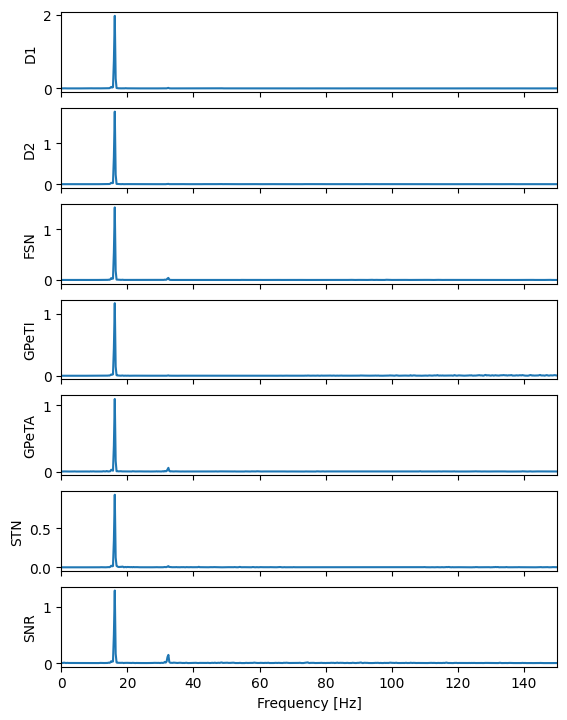

In [13]:
plot_spectrum(sn, scale="linear")

(2.5, 3.0)

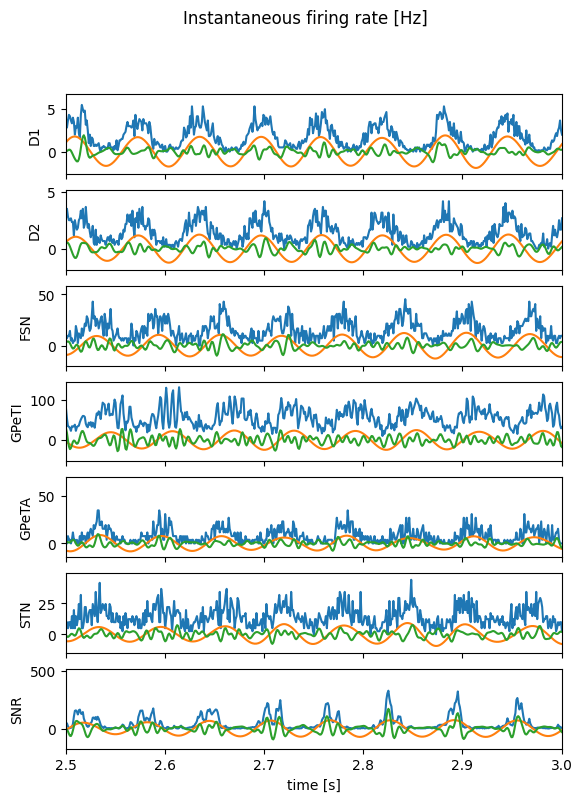

In [14]:
plot_signals(sn)
plt.gca().set_xlim(2.5, 3)